In [1]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [9]:
query = """select *
        from eigensonne_dwh.public.lead_scoring_sample_1 """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,lead_campaign,bundesland,closest_team,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Website,None,None,Schleswig-Holstein,hotel,35,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,Wattfox,affiliate,wattfox-standard,Bayern,echo,35,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,Wattfox,affiliate,wattfox-standard,Baden-Württemberg,india,35,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,Wattfox,affiliate,wattfox-standard,Bayern,echo,75,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,Wattfox,affiliate,wattfox-standard,Nordrhein-Westfalen,juliett,35,18,Regular,1,0,0,14,1


In [10]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [11]:
print(base.shape)
base.dtypes

(13917, 14)


id                           object
lead_source                  object
lead_medium                  object
lead_campaign                object
bundesland                   object
closest_team                 object
radius_category              object
distance                      int64
record_type_name_c           object
has_opened                    int64
has_clicked_non_photo_url     int64
photo_upload                  int64
duration_photo_upload         int64
has_reached_wfp               int64
dtype: object

In [12]:
#drop data closest team and radius category cause of duplocates
# for testing reasons also gonna delete source
base=base.drop(['closest_team','radius_category','lead_source'],1)

In [13]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13917 entries, 0 to 13916
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         13917 non-null  object
 1   lead_medium                13188 non-null  object
 2   lead_campaign              12941 non-null  object
 3   bundesland                 13917 non-null  object
 4   distance                   13917 non-null  int64 
 5   record_type_name_c         13917 non-null  object
 6   has_opened                 13917 non-null  int64 
 7   has_clicked_non_photo_url  13917 non-null  int64 
 8   photo_upload               13917 non-null  int64 
 9   duration_photo_upload      13917 non-null  int64 
 10  has_reached_wfp            13917 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.2+ MB


In [14]:
base.describe()

,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
count,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000,13917.000000
mean,43.723432,0.677660,0.074872,0.072789,7.323274,0.254006
std,30.009559,0.467389,0.263195,0.259799,9.655062,0.435317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,1.000000,0.000000,0.000000,2.000000,0.000000
75%,60.000000,1.000000,0.000000,0.000000,14.000000,1.000000
max,279.000000,1.000000,1.000000,1.000000,101.000000,1.000000


In [15]:
base.isnull().sum()

id                             0
lead_medium                  729
lead_campaign                976
bundesland                     0
distance                       0
record_type_name_c             0
has_opened                     0
has_clicked_non_photo_url      0
photo_upload                   0
duration_photo_upload          0
has_reached_wfp                0
dtype: int64

In [16]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                           0.00
lead_medium                  5.24
lead_campaign                7.01
bundesland                   0.00
distance                     0.00
record_type_name_c           0.00
has_opened                   0.00
has_clicked_non_photo_url    0.00
photo_upload                 0.00
duration_photo_upload        0.00
has_reached_wfp              0.00
dtype: float64

In [17]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

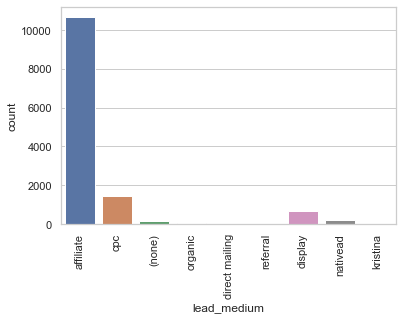

In [18]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [19]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)              166
affiliate         10673
cpc                1424
direct mailing        1
display             651
kristina              1
nativead            206
organic              52
referral             14
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

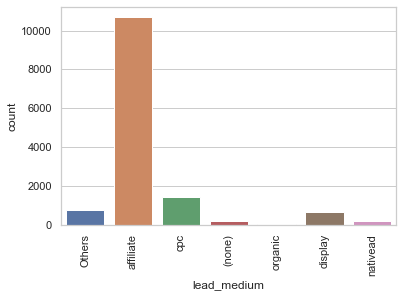

In [22]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_medium.transform('count').lt(30),
                               'lead_medium'],'Others')

sns.countplot(data['lead_medium'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 <a list of 76 Text major ticklabel objects>)

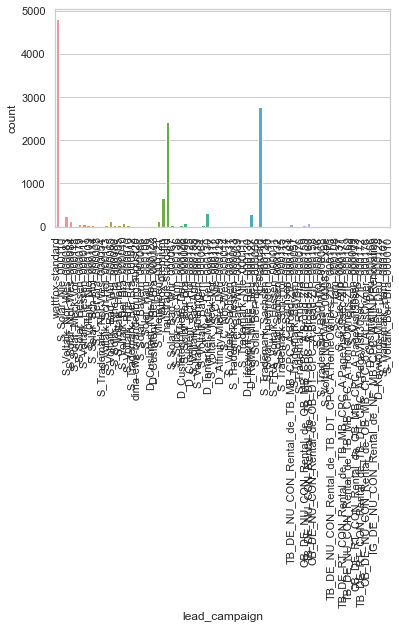

In [23]:
#there are too many different categories that variate too much among each other so this is not reliable
sns.countplot(data['lead_campaign'])
xticks(rotation = 90)

In [24]:
data = data.drop(['lead_campaign'],1)

In [25]:
data['record_type_name_c'].describe()


count       13917
unique          2
top       Regular
freq        11244
Name: record_type_name_c, dtype: object

In [26]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                           0.0
lead_medium                  0.0
bundesland                   0.0
distance                     0.0
record_type_name_c           0.0
has_opened                   0.0
has_clicked_non_photo_url    0.0
photo_upload                 0.0
duration_photo_upload        0.0
has_reached_wfp              0.0
dtype: float64

In [27]:
#Exploratory Data Analytics
# Univariate Analysis 

In [28]:
Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

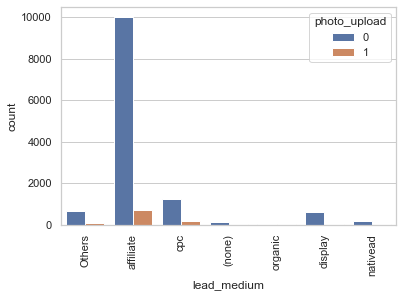

In [30]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_upload", data = data)
xticks(rotation = 90)

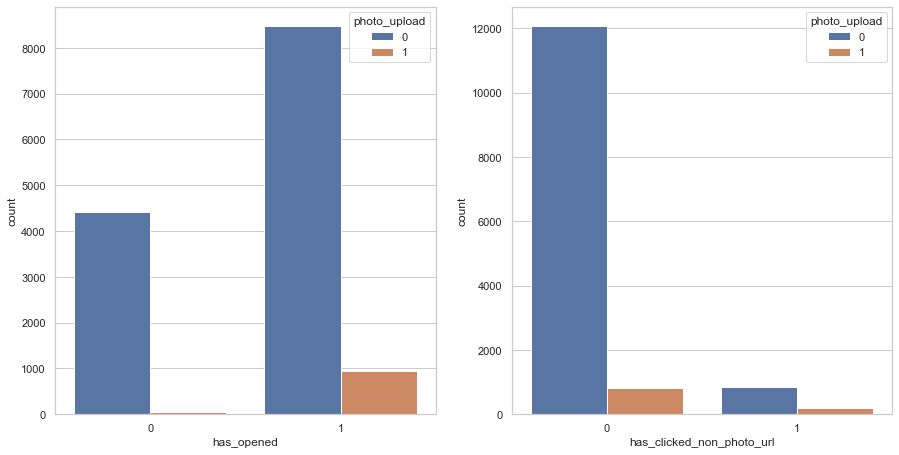

In [31]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_upload", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_upload", data = data, ax = axs[1])

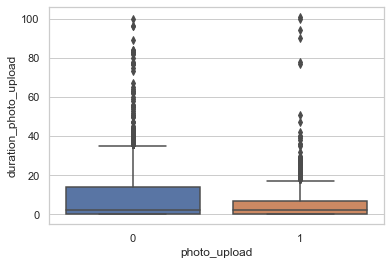

In [32]:
sns.boxplot(y = 'duration_photo_upload', x = 'photo_upload', data = data)

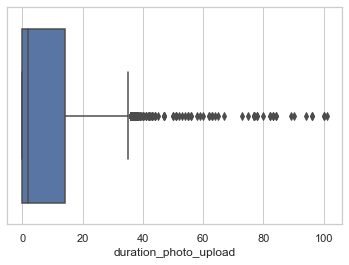

In [33]:
sns.boxplot(data['duration_photo_upload'])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

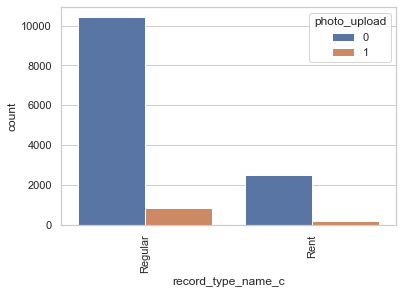

In [34]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_upload", data = data)
xticks(rotation = 90)

In [35]:
data.head(10)

,id,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp
0,00Q5J000002qx3WUAQ,Others,Schleswig-Holstein,24,Regular,1,0,0,14,1
1,00Q5J000002qx7dUAA,affiliate,Bayern,18,Regular,1,0,0,8,0
2,00Q5J000002qx7jUAA,affiliate,Baden-Württemberg,31,Regular,1,0,0,18,1
3,00Q5J000002qx7JUAQ,affiliate,Bayern,53,Regular,1,0,0,14,1
4,00Q5J000002qx7TUAQ,affiliate,Nordrhein-Westfalen,18,Regular,1,0,0,14,1
5,00Q5J000002qx7xUAA,affiliate,Berlin,14,Regular,0,0,0,40,0
6,00Q5J000002qx8bUAA,affiliate,Hessen,60,Regular,0,0,0,8,0
7,00Q5J000002qx8lUAA,affiliate,Nordrhein-Westfalen,30,Regular,1,0,0,15,1
8,00Q5J000002qx9UUAQ,affiliate,Hessen,13,Regular,1,0,0,14,1
9,00Q5J000002qxaQUAQ,affiliate,Nordrhein-Westfalen,29,Rent,1,0,0,19,0


In [36]:
# Data Preparation



In [38]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c',
                           'lead_medium','bundesland']], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [39]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_medium,bundesland,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,Others,Schleswig-Holstein,24,Regular,1,0,0,14,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,affiliate,Bayern,18,Regular,1,0,0,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,affiliate,Baden-Württemberg,31,Regular,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,affiliate,Bayern,53,Regular,1,0,0,14,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,affiliate,Nordrhein-Westfalen,18,Regular,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [40]:
data = data.drop(['lead_medium',	'bundesland',
                             'record_type_name_c'], axis = 1)


In [41]:
data.head(10)

,id,distance,has_opened,has_clicked_non_photo_url,photo_upload,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,00Q5J000002qx3WUAQ,24,1,0,0,14,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00Q5J000002qx7dUAA,18,1,0,0,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000002qx7jUAA,31,1,0,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000002qx7JUAQ,53,1,0,0,14,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000002qx7TUAQ,18,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00Q5J000002qx7xUAA,14,0,0,0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000002qx8bUAA,60,0,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,00Q5J000002qx8lUAA,30,1,0,0,15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00Q5J000002qx9UUAQ,13,1,0,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,00Q5J000002qxaQUAQ,29,1,0,0,19,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [42]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_upload'], axis=1)
X.head()

,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
0,24,1,0,14,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,18,1,0,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31,1,0,18,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53,1,0,14,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,1,0,14,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [43]:
y = data['photo_upload']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_upload, dtype: int64

In [44]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=None)

In [45]:
#feature scaling
scaler = StandardScaler()

X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
    X_train[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-45-732c84c0a684>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['distance','duration_photo_upload']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
5953,-1.088321,1,1,-0.758058,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13207,0.236010,0,0,0.069888,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10810,-0.657913,0,0,0.690847,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12573,-0.095073,1,0,0.276874,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11714,0.302226,1,0,-0.758058,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
#How many conversions do we have 

Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

7.278867572034203

In [40]:
#Model building 

In [47]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9713
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1625.0
Date:                Thu, 21 Jan 2021   Deviance:                       3249.9
Time:                        21:16:03   Pearson chi2:                 5.45e+08
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -5.0715      0.424    -11.964      0.000      -5.902      -4.241
distance                             -0.0722      0.064     -1.126      0.260      -0.198       0.053
has_opened                            1.7576      0.179      9.799      0.000       1.406       2.109
has_clicked_non_photo_url             0.6589      0.131      5.027      0.000       0.402       0.916
duration_photo_upload                -1.6218      0.085    -19.181      0.000      -1.788      -1.456
has_reached_wfp                       4.0029      0.129     30.924      0.000       3.749       4.257
record_type_name_c_Rent              -0.3094      0.124     -2.492      0.013      -0.553      -0.066
lead_medium_Others                   -0.0568      0.419     -0.136      0.892      -0.877       0.764
lead_medium_affiliate                -1.2108      0.380     -3.190      0.001      -1.955      -0.467
lead_medium_cpc                      -0.2787      0.393     -0.709      0.478      -1.049       0.492
lead_medium_display                  -0.9033      0.459     -1.967      0.049      -1.803      -0.003
lead_medium_nativead                 -0.9825      0.569     -1.726      0.084      -2.098       0.133
lead_medium_organic                  -0.2923      0.888     -0.329      0.742      -2.033       1.448
bundesland_Bayern                    -0.1196      0.261     -0.457      0.647      -0.632       0.393
bundesland_Berlin                    -0.0090      0.252     -0.036      0.971      -0.502       0.484
bundesland_Brandenburg               -0.3599      0.192     -1.872      0.061      -0.737       0.017
bundesland_Bremen                     4.8712      1.340      3.636      0.000       2.245       7.497
bundesland_Hamburg                    0.3011      0.376      0.801      0.423      -0.436       1.038
bundesland_Hessen                    -0.3629      0.189     -1.921      0.055      -0.733       0.007
bundesland_Mecklenburg-Vorpommern    -0.2159      0.584     -0.370      0.712      -1.360       0.929
bundesland_Niedersachsen             -0.4180      0.230     -1.813      0.070      -0.870       0.034
bundesland_Nordrhein-Westfalen       -0.2236      0.145     -1.537      0.124      -0.509       0.062
bundesland_Rheinland-Pfalz           -0.0131      0.223     -0.059      0.953      -0.450       0.424
bundesland_Saarland                 -19.6474   1.51e+04     -0.001      0.999   -2.95e+04    2.95e+04
bundesland_Sachsen                   -0.5945      0.424     -1.401      0.161      -1.426       0.237
bundesland_Sachsen-Anhalt            -0.0363      0.381     -0.095      0.924      -0.784       0.711
bundesland_Schleswig-Holstein        -0.0994      0.263     -0.377      0.706      -0.616       0.417
bundesland_Thüringen   

In [48]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([False,  True,  True,  True,  True,  True, False,  True, False,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True, False, False,  True,  True, False, False,  True])

In [49]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('distance', False, 7),
 ('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('duration_photo_upload', True, 1),
 ('has_reached_wfp', True, 1),
 ('record_type_name_c_Rent', True, 1),
 ('lead_medium_Others', False, 4),
 ('lead_medium_affiliate', True, 1),
 ('lead_medium_cpc', False, 12),
 ('lead_medium_display', True, 1),
 ('lead_medium_nativead', True, 1),
 ('lead_medium_organic', False, 9),
 ('bundesland_Bayern', False, 6),
 ('bundesland_Berlin', False, 10),
 ('bundesland_Brandenburg', False, 2),
 ('bundesland_Bremen', True, 1),
 ('bundesland_Hamburg', True, 1),
 ('bundesland_Hessen', True, 1),
 ('bundesland_Mecklenburg-Vorpommern', False, 3),
 ('bundesland_Niedersachsen', True, 1),
 ('bundesland_Nordrhein-Westfalen', False, 5),
 ('bundesland_Rheinland-Pfalz', False, 11),
 ('bundesland_Saarland', True, 1),
 ('bundesland_Sachsen', True, 1),
 ('bundesland_Sachsen-Anhalt', False, 13),
 ('bundesland_Schleswig-Holstein', False, 8),
 ('bundesland_Thüringen', True, 1)]

In [50]:
col = X_train.columns[rfe.support_]
col

Index(['has_opened', 'has_clicked_non_photo_url', 'duration_photo_upload',
       'has_reached_wfp', 'record_type_name_c_Rent', 'lead_medium_affiliate',
       'lead_medium_display', 'lead_medium_nativead', 'bundesland_Bremen',
       'bundesland_Hamburg', 'bundesland_Hessen', 'bundesland_Niedersachsen',
       'bundesland_Saarland', 'bundesland_Sachsen', 'bundesland_Thüringen'],
      dtype='object')

In [51]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9725
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1628.7
Date:                Thu, 21 Jan 2021   Deviance:                       3257.4
Time:                        21:16:19   Pearson chi2:                 5.67e+08
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.3941      0.201    -26.832      0.000      -5.788      -5.000
has_opened                    1.7296      0.178      9.709      0.000       1.380       2.079
has_clicked_non_photo_url     0.6712      0.131      5.140      0.000       0.415       0.927
duration_photo_upload        -1.6275      0.084    -19.306      0.000      -1.793      -1.462
has_reached_wfp               3.9997      0.129     31.069      0.000       3.747       4.252
record_type_name_c_Rent      -0.3082      0.124     -2.494      0.013      -0.551      -0.066
lead_medium_affiliate        -1.0094      0.117     -8.636      0.000      -1.238      -0.780
lead_medium_display          -0.7231      0.286     -2.529      0.011      -1.284      -0.163
lead_medium_nativead         -0.7858      0.441     -1.784      0.074      -1.649       0.078
bundesland_Bremen             4.8959      1.333      3.673      0.000       2.283       7.509
bundesland_Hamburg            0.5091      0.356      1.430      0.153      -0.189       1.207
bundesland_Hessen            -0.2026      0.155     -1.308      0.191      -0.506       0.101
bundesland_Niedersachsen     -0.2749      0.203     -1.353      0.176      -0.673       0.123
bundesland_Saarland         -19.7026   1.51e+04     -0.001      0.999   -2.96e+04    2.96e+04
bundesland_Sachsen           -0.4594      0.409     -1.124      0.261      -1.260       0.341
bundesland_Thüringen         -0.7430      0.694     -1.070      0.285      -2.104       0.618
=============================================================================================
"""

In [52]:
col2 = col.drop(['bundesland_Niedersachsen','bundesland_Sachsen','bundesland_Saarland',
                  'bundesland_Thüringen','bundesland_Hamburg','bundesland_Hessen'],1)
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                 9741
Model:                            GLM   Df Residuals:                     9731
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1633.2
Date:                Thu, 21 Jan 2021   Deviance:                       3266.5
Time:                        21:17:34   Pearson chi2:                 5.53e+08
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.4302      0.200    -27.209      0.000      -5.821      -5.039
has_opened                    1.7322      0.178      9.727      0.000       1.383       2.081
has_clicked_non_photo_url     0.6660      0.130      5.103      0.000       0.410       0.922
duration_photo_upload        -1.6210      0.084    -19.308      0.000      -1.786      -1.456
has_reached_wfp               3.9977      0.128     31.138      0.000       3.746       4.249
record_type_name_c_Rent      -0.3061      0.123     -2.488      0.013      -0.547      -0.065
lead_medium_affiliate        -1.0173      0.116     -8.742      0.000      -1.245      -0.789
lead_medium_display          -0.7351      0.284     -2.587      0.010      -1.292      -0.178
lead_medium_nativead         -0.8113      0.437     -1.855      0.064      -1.668       0.046
bundesland_Bremen             4.9442      1.331      3.714      0.000       2.335       7.553
=============================================================================================
"""

In [53]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

5953     0.704973
13207    0.071549
10810    0.027392
12573    0.237493
11714    0.029699
213      0.087388
5904     0.078049
1955     0.004557
13030    0.025228
3431     0.000517
dtype: float64

In [54]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([7.04972602e-01, 7.15487854e-02, 2.73917503e-02, 2.37492865e-01,
       2.96988325e-02, 8.73878263e-02, 7.80491804e-02, 4.55727203e-03,
       2.52275936e-02, 5.16750956e-04])

In [55]:
#
y_train_pred_final = pd.DataFrame({'photo_upload':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id
0,1,0.704973,5953
1,0,0.071549,13207
2,0,0.027392,10810
3,0,0.237493,12573
4,0,0.029699,11714


In [56]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted
0,1,0.704973,5953,1
1,0,0.071549,13207,0
2,0,0.027392,10810,0
3,0,0.237493,12573,0
4,0,0.029699,11714,0


In [57]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
print(confusion)


[[8918   84]
 [ 387  352]]


In [58]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.predicted))

0.951647674776717


In [59]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
0,has_opened,2.69
5,lead_medium_affiliate,2.65
3,has_reached_wfp,1.53
4,record_type_name_c_Rent,1.39
6,lead_medium_display,1.22
1,has_clicked_non_photo_url,1.19
2,duration_photo_upload,1.11
7,lead_medium_nativead,1.08
8,bundesland_Bremen,1.01


In [60]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [61]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.476319350473613

In [62]:
# Let us calculate specificity
TN / float(TN+FP)

0.9906687402799378

In [63]:
# positive predictive value 
print (TP / float(TP+FP))

0.8073394495412844


In [64]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9584094572810317


In [65]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

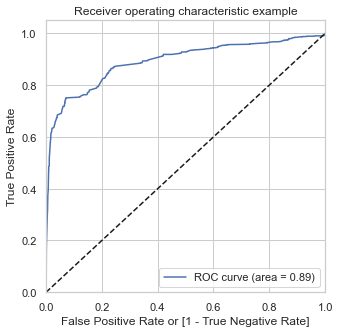

In [66]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_upload, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

In [67]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.704973,5953,1,1,1,1,1,1,1,1,1,0,0
1,0,0.071549,13207,0,1,0,0,0,0,0,0,0,0,0
2,0,0.027392,10810,0,1,0,0,0,0,0,0,0,0,0
3,0,0.237493,12573,0,1,1,1,0,0,0,0,0,0,0
4,0,0.029699,11714,0,1,0,0,0,0,0,0,0,0,0


In [68]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.075865  1.000000  0.000000
0.1   0.1  0.845601  0.771313  0.851700
0.2   0.2  0.923314  0.711773  0.940680
0.3   0.3  0.944667  0.650880  0.968785
0.4   0.4  0.953701  0.565629  0.985559
0.5   0.5  0.951648  0.476319  0.990669
0.6   0.6  0.943230  0.304465  0.995668
0.7   0.7  0.936967  0.185386  0.998667
0.8   0.8  0.929576  0.074425  0.999778
0.9   0.9  0.924135  0.000000  1.000000


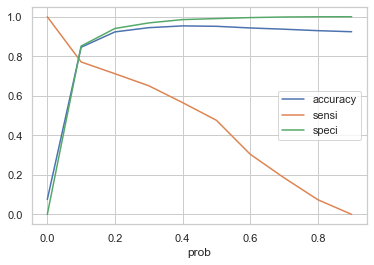

In [69]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [70]:
#### From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.704973,5953,1,1,1,1,1,1,1,1,1,0,0,1
1,0,0.071549,13207,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.027392,10810,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.237493,12573,0,1,1,1,0,0,0,0,0,0,0,1
4,0,0.029699,11714,0,1,0,0,0,0,0,0,0,0,0,0


In [71]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,1,0.704973,5953,1,1,1,1,1,1,1,1,1,0,0,1,70
1,0,0.071549,13207,0,1,0,0,0,0,0,0,0,0,0,0,7
2,0,0.027392,10810,0,1,0,0,0,0,0,0,0,0,0,0,3
3,0,0.237493,12573,0,1,1,1,0,0,0,0,0,0,0,1,24
4,0,0.029699,11714,0,1,0,0,0,0,0,0,0,0,0,0,3


In [72]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7117726657645467

In [73]:
# Let us calculate specificity
TN / float(TN+FP)

0.9406798489224617

In [74]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.059320151077538325


In [75]:
# Positive predictive value 
print (TP / float(TP+FP))

0.4962264150943396


In [76]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9754636562607994


In [77]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
confusion

array([[8918,   84],
       [ 387,  352]])

In [78]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8073394495412844

In [79]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.476319350473613

In [80]:
y_train_pred_final.photo_upload, y_train_pred_final.predicted

(0       1
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: photo_upload, Length: 9741, dtype: int64,
 0       1
 1       0
 2       0
 3       0
 4       0
        ..
 9736    0
 9737    0
 9738    0
 9739    0
 9740    0
 Name: predicted, Length: 9741, dtype: int64)

In [81]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

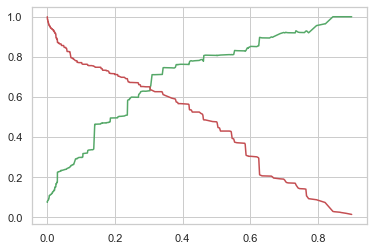

In [82]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [83]:
#Making predictions on the test set

X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])

X_train.head()

<ipython-input-83-42eb147c9bee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['distance','duration_photo_upload']] = scaler.fit_transform(X_test[['distance','duration_photo_upload']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,distance,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Bremen,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Saarland,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen
5953,-1.088321,1,1,-0.758058,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13207,0.236010,0,0,0.069888,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10810,-0.657913,0,0,0.690847,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
12573,-0.095073,1,0,0.276874,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11714,0.302226,1,0,-0.758058,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
X_test = X_test[col2]
X_test.head()

,has_opened,has_clicked_non_photo_url,duration_photo_upload,has_reached_wfp,record_type_name_c_Rent,lead_medium_affiliate,lead_medium_display,lead_medium_nativead,bundesland_Bremen
7022,1,0,-0.759596,0,1,1,0,0,0
4522,1,0,0.693198,1,1,1,0,0,0
8582,1,0,-0.655825,0,0,0,1,0,0
3428,0,0,-0.448283,0,0,1,0,0,0
11026,1,0,-0.759596,0,0,1,0,0,0


In [85]:
X_test_sm = sm.add_constant(X_test)

In [86]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


7022     0.022095
4522     0.104573
8582     0.033247
3428     0.003266
11026    0.029771
4803     0.025278
4582     0.104573
8022     0.022095
12900    0.027290
8140     0.002335
dtype: float64

In [87]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
7022,0.022095
4522,0.104573
8582,0.033247
3428,0.003266
11026,0.029771


In [88]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_upload,id,0
0,0,7022,0.022095
1,0,4522,0.104573
2,0,8582,0.033247
3,0,3428,0.003266
4,0,11026,0.029771


In [89]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_upload,id,photo_upload_prob
0,0,7022,0.022095
1,0,4522,0.104573
2,0,8582,0.033247
3,0,3428,0.003266
4,0,11026,0.029771


In [90]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_upload,id,photo_upload_prob,final_predicted
0,0,7022,0.022095,0
1,0,4522,0.104573,0
2,0,8582,0.033247,0
3,0,3428,0.003266,0
4,0,11026,0.029771,0


In [91]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_upload, y_pred_final.final_predicted)

0.9212164750957854

In [92]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_upload, y_pred_final.final_predicted )
confusion2

array([[3659,  243],
       [  86,  188]])

In [93]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [94]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6861313868613139

In [95]:
# Let us calculate specificity
TN / float(TN+FP)

0.9377242439774475